# **02 Model evolution along a *P*–*T*-path**
---

This notebook shows you how to:
1. Model the system evolution of a rock along a predefined *P*–*T*-trajectory, by:
    * Automatically calling repeated Theriak minimisations.
    * Forwarding of bulk rock composition.
2. Visualisation of mineral modes an compostion as a function of *P* and *T*.
3. Fractionated phases for modelling along a *P*–*T*-path with evolving reactive bulk rock composition.

**Requirements:**
- python >= 3.10
*with the following packages installed:*
- pytheriak
- matplotlib
- ...

*Theriak-Domino back-end:*
- A working Theriak-Domino installation.
- Thermodynamic databases to use with Theriak in the working directory.
---

### Import all required libraries.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from pytheriak import wrapper

### Initiate a TherCaller-object.
The argument `programs_dir` must be set to the directory of your Theriak_Domino installation.

In [2]:
theriak = wrapper.TherCaller(programs_dir="C:\\TheriakDominoWIN\\Programs",
                             database="td-ds62-mb50-v07.txt",
                             theriak_version="v28.05.2022")

### Set model parameter
*P*–*T*-path from Gerya et al. (2002) in Vho et al. (2020) Fig. 2 (https://doi.org/10.5194/se-11-307-2020).\
TODO: Add in refenrence to Thorstens P-T-path extraction tool.\
\
*Bulk rock compositions of unaltered and altered metabaslat in Vho et al. (2020) (https://doi.org/10.5194/se-11-307-2020).*


In [3]:
pt_path = np.loadtxt(Path("PTpath_Gerya2002.txt")).T
bulk_MORB = "SI(44.78)TI(1.12)AL(15.37)FE(7.74)MN(0.00)MG(10.03)CA(10.83)NA(4.80)K(0.18)H(30.64)O(?)"
bulk_AOC = "SI(41.37)TI(0.76)AL(16.54)FE(4.76)MN(0.00)MG(8.97)CA(12.46)NA(3.61)K(0.64)H(35.28)O(?)"

In [5]:
lawsonite_stable = []
lawsonite_vol_percent = []
lawsonite_dG = []
rocks = []

for temperature, pressure in pt_path:
    rock, element_list = theriak.minimisation(pressure, temperature, bulk_MORB, return_failed_minimisation=True)

    # look for lawsonite in the names of the mineral assemblage
    mineral_names = [mineral.name for mineral in rock.mineral_assemblage]
    law_stable = "law" in mineral_names
    lawsonite_stable.append(law_stable)

    if law_stable:
        law_idx = mineral_names.index("law")
        lawsonite_vol_percent.append(rock.mineral_assemblage[law_idx].vol_percent)
        lawsonite_dG.append(None)
    else:
        lawsonite_vol_percent.append(None)
        lawsonite_dG.append(dict(rock.mineral_delta_G)["law"])

    rocks.append(rock)

In [7]:
laws_in_MORB = pd.DataFrame({"Temperature": pt_path[:, 0],
                             "Pressure": pt_path[:, 1],
                             "Lawsonite stable": lawsonite_stable,
                             "Lawsonite vol %": lawsonite_vol_percent,
                             "Lawsonite dG": lawsonite_dG})

<Axes: xlabel='Temperature', ylabel='Pressure'>

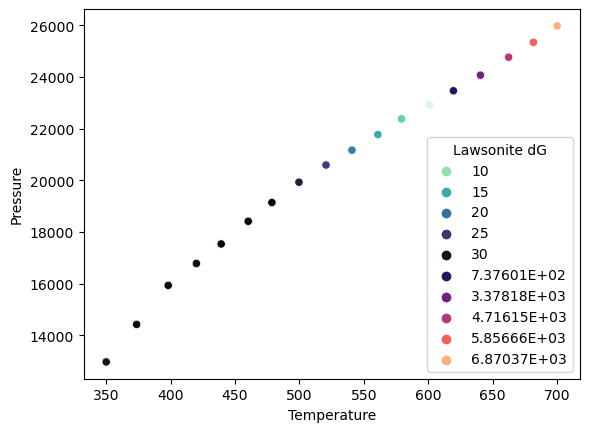

In [22]:
fig, axs = plt.subplots()

sns.scatterplot(data=laws_in_MORB, x="Temperature", y="Pressure", palette="mako_r", hue="Lawsonite vol %", ax=axs)
sns.scatterplot(data=laws_in_MORB, x="Temperature", y="Pressure", palette="magma", hue="Lawsonite dG", ax=axs)

However, from the petrography of lawsonite-bearing blueschists and eclogites we now that lawsonite tends to form big porphyroblasts. Equilibration of such porphyroblasts is believed to often be kinetically inhibited. Like this the elements bound in the lawsonite is effectively removed from the reactive bulk rock compostion.\

To account for this in our model we must update our bulk rock compostion if a fractionating (porphyroblast-forming) phase has formed.

In [24]:
def bulk_from_compositionalvector(composition: list | np.ndarray, element_list: list | np.ndarray):
    bulk = ""
    for moles, element in zip(composition, element_list):
        bulk += element
        bulk += "(" + str(moles) + ")"

    return bulk

In [30]:
lawsonite_stable = []
garnet_stable = []
lawsonite_vol_percent = []
garnet_vol_percent = []
lawsonite_dG = []
rocks = []

# initiate list for lws and grt volumes with 0
lawsonite_vol = [0]
garnet_vol = [0]

reactive_bulk = bulk_MORB

for temperature, pressure in pt_path:
    rock, element_list = theriak.minimisation(pressure, temperature, reactive_bulk, return_failed_minimisation=True)

    # look for lawsonite in the names of the mineral assemblage
    mineral_names = [mineral.name for mineral in rock.mineral_assemblage]
    law_stable = "law" in mineral_names
    lawsonite_stable.append(law_stable)

    # for garnet all possible solutions (all starting with "GRT_") must be checked
    grt_stable = len([name for name in mineral_names if str.startswith(name, "GRT_")]) != 0
    garnet_stable.append(grt_stable)

    if law_stable:
        law_idx = mineral_names.index("law")
        lawsonite_vol_crystallised = (rock.mineral_assemblage[law_idx].vol)
        lws_composition_moles = np.array(rock.mineral_assemblage[law_idx].composition_moles)

        lawsonite_dG.append(None)


    else:
        lawsonite_vol_crystallised = 0
        lawsonite_dG.append(dict(rock.mineral_delta_G)["law"])
        lws_composition_moles = np.zeros(len(element_list))

    if grt_stable:
        grt_idx = mineral_names.index([name for name in mineral_names if str.startswith(name, "GRT_")][0])
        garnet_vol_crystallised = (rock.mineral_assemblage[grt_idx].vol)
        grt_composition_moles = np.array(rock.mineral_assemblage[grt_idx].composition_moles)

    else:
        garnet_vol_crystallised = 0
        grt_composition_moles = np.zeros(len(element_list))

    rock_vol = sum([mineral.vol for mineral in rock.mineral_assemblage])
    lawsonite_vol_percent.append((lawsonite_vol_crystallised + lawsonite_vol[-1]) / (rock_vol + lawsonite_vol[-1] + garnet_vol[-1]) * 100)
    garnet_vol_percent.append((garnet_vol_crystallised + garnet_vol[-1]) / (rock_vol + lawsonite_vol[-1] + garnet_vol[-1]) * 100)

    lawsonite_vol.append(lawsonite_vol_crystallised + lawsonite_vol[-1])
    garnet_vol.append(garnet_vol_crystallised + garnet_vol[-1])

    # fractionate bulk
    bulk = np.array(rock.bulk_composition_moles)
    reactive_bulk = bulk_from_compositionalvector(bulk - lws_composition_moles - grt_composition_moles, element_list)
    rocks.append(rock)

# drop first entries in lawsonite and garnet volume lists
lawsonite_vol = lawsonite_vol[1:]
garnet_vol = garnet_vol[1:]

    478.62500000000006    19137.67019667171
1   O(108.084078)SI(34.143815000000004)TI(1.12)AL(4.733815)FE(7.74)MG(10.03)CA(5.511908)NA(4.8)K(0.18)H(9.367631999999999)    *


In [36]:
laws_in_MORB_fractionated = pd.DataFrame({"Temperature": pt_path[:, 0],
                             "Pressure": pt_path[:, 1],
                             "Lawsonite stable": lawsonite_stable,
                             "Lawsonite vol %": lawsonite_vol_percent,
                             "Lawsonite dG": np.float_(lawsonite_dG)})

In [38]:
# remove entries of failed minimisations
laws_in_MORB_fractionated = laws_in_MORB_fractionated[laws_in_MORB_fractionated["Temperature"] != 478.62500000000006]

<Axes: xlabel='Temperature', ylabel='Pressure'>

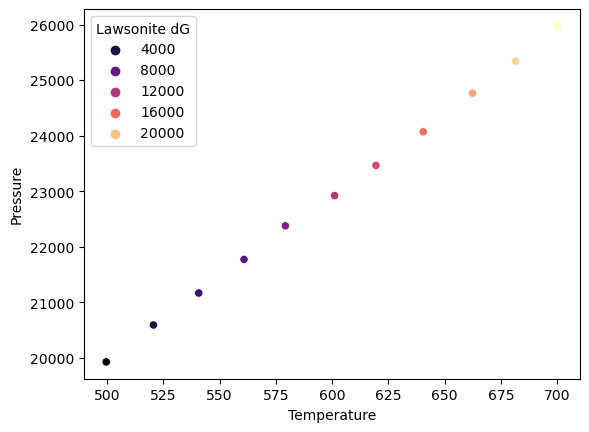

In [39]:
fig, axs = plt.subplots()

# sns.scatterplot(data=laws_in_MORB_fractionated, x="Temperature", y="Pressure", palette="mako_r", hue="Lawsonite vol %", ax=axs)
sns.scatterplot(data=laws_in_MORB_fractionated, x="Temperature", y="Pressure", palette="magma", hue="Lawsonite dG", ax=axs)